In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.cluster import KMeans

from shapkit.shapley_values import ShapleyValues
from shapkit.inspector import inspector
from shapkit.monte_carlo_shapley import MonteCarloShapley
from shapkit.sgd_shapley import SGDshapley
from shapkit.plots import plot_shapley

%load_ext autoreload
%autoreload 2

# Load dataset

In [2]:
from sklearn.datasets import load_wine
wine = load_wine()
columns = wine.feature_names
target_names = wine.target_names
X = pd.DataFrame(wine.data, columns=columns)
y = wine.target
print("Classes: {0}".format(np.unique(y)))
X.head(3)

Classes: [0 1 2]


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0



# Train a ML model

In [3]:
model = KMeans(n_clusters=3, random_state=0).fit(X)

# Define the game

In [4]:
d = X.shape[1]
n = 2**d - 2
d, n

(13, 8190)

### Pick an individual x to explain

In [5]:
x = X.iloc[np.random.choice(len(X), size=1)[0],:]
x_class = int(model.predict(x.values.reshape(1,-1)))
print(x)
print()
print("Class for x: {0:.0f}".format(x_class))

alcohol                           14.21
malic_acid                         4.04
ash                                2.44
alcalinity_of_ash                 18.90
magnesium                        111.00
total_phenols                      2.85
flavanoids                         2.65
nonflavanoid_phenols               0.30
proanthocyanins                    1.25
color_intensity                    5.24
hue                                0.87
od280/od315_of_diluted_wines       3.33
proline                         1080.00
Name: 45, dtype: float64

Class for x: 1


### Reward function

In [6]:
fc = lambda x: 1 if int(model.predict(x.reshape(1,-1))) == int(x_class) else 0

### Single reference

In [7]:
X_opposite_class = X[model.predict(X) != x_class].copy()
reference = X_opposite_class.iloc[np.random.choice(len(X_opposite_class), size=1)[0],:]
ref_class = int(model.predict(reference.values.reshape(1,-1)))
print(reference)
print()
print("Prediction class for this reference: {0:.0f}".format(ref_class))

alcohol                          12.81
malic_acid                        2.31
ash                               2.40
alcalinity_of_ash                24.00
magnesium                        98.00
total_phenols                     1.15
flavanoids                        1.09
nonflavanoid_phenols              0.27
proanthocyanins                   0.83
color_intensity                   5.70
hue                               0.66
od280/od315_of_diluted_wines      1.36
proline                         560.00
Name: 132, dtype: float64

Prediction class for this reference: 2


#### Approximation methods

##### Monte Carlo 

In [8]:
mc_shap = MonteCarloShapley(x=x, fc=fc, ref=reference, n_iter=100)
mc_shap

100%|██████████| 100/100 [00:00<00:00, 176.43it/s]


alcohol                         0.0
malic_acid                      0.0
ash                             0.0
alcalinity_of_ash               0.0
magnesium                       0.0
total_phenols                   0.0
flavanoids                      0.0
nonflavanoid_phenols            0.0
proanthocyanins                 0.0
color_intensity                 0.0
hue                             0.0
od280/od315_of_diluted_wines    0.0
proline                         1.0
dtype: float64

##### SGD

In [9]:
sgd_est = SGDshapley(d, C=y.max())
sgd_shap = sgd_est.sgd(x=x, fc=fc, ref=reference, n_iter=500, step=.1, step_type="sqrt")
sgd_shap

100%|██████████| 500/500 [00:00<00:00, 1335.47it/s]


alcohol                         0.044884
malic_acid                      0.047367
ash                            -0.012657
alcalinity_of_ash              -0.057488
magnesium                      -0.056382
total_phenols                   0.035235
flavanoids                      0.001852
nonflavanoid_phenols           -0.038381
proanthocyanins                 0.075550
color_intensity                 0.094319
hue                             0.025291
od280/od315_of_diluted_wines   -0.000266
proline                         0.840677
dtype: float64

#### Plot 

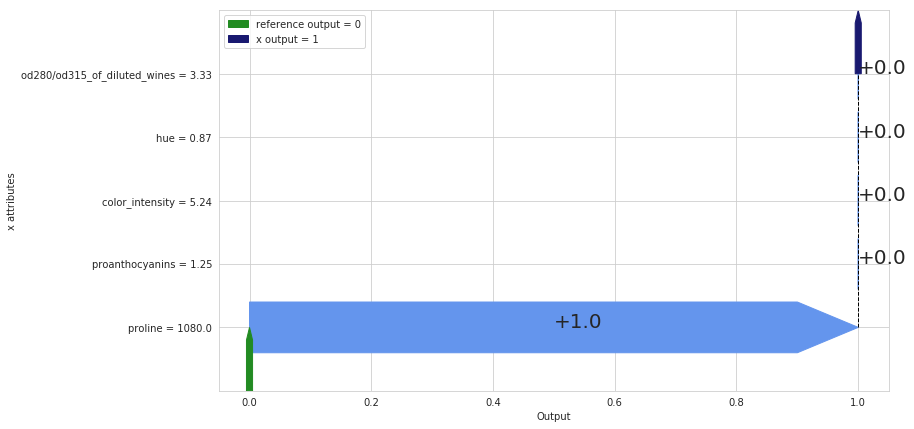

In [10]:
plot_shapley(x=x, fc=fc, ref=reference, shapley_values=mc_shap, n_attributes=5)

### Several references 

In [11]:
n_ref = 10
idx_ref = np.random.choice(X_opposite_class.shape[0], size=n_ref, replace=False).flatten()
references = X_opposite_class.iloc[idx_ref]
references.head(5)

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
95,12.47,1.52,2.20,19.0,162.0,2.50,2.27,0.32,3.28,2.60,1.16,2.63,937.0
87,11.65,1.67,2.62,26.0,88.0,1.92,1.61,0.40,1.34,2.60,1.36,3.21,562.0
40,13.56,1.71,2.31,16.2,117.0,3.15,3.29,0.34,2.34,6.13,0.95,3.38,795.0
84,11.84,0.89,2.58,18.0,94.0,2.20,2.21,0.22,2.35,3.05,0.79,3.08,520.0
170,12.20,3.03,2.32,19.0,96.0,1.25,0.49,0.40,0.73,5.50,0.66,1.83,510.0


#### Approximation methods

##### Monte Carlo 

In [12]:
mc_shaps = MonteCarloShapley(x=x, fc=fc, ref=references, n_iter=100)
mc_shaps

100%|██████████| 100/100 [00:00<00:00, 162.40it/s]


alcohol                         0.0
malic_acid                      0.0
ash                             0.0
alcalinity_of_ash               0.0
magnesium                       0.0
total_phenols                   0.0
flavanoids                      0.0
nonflavanoid_phenols            0.0
proanthocyanins                 0.0
color_intensity                 0.0
hue                             0.0
od280/od315_of_diluted_wines    0.0
proline                         1.0
dtype: float64

#### Plots

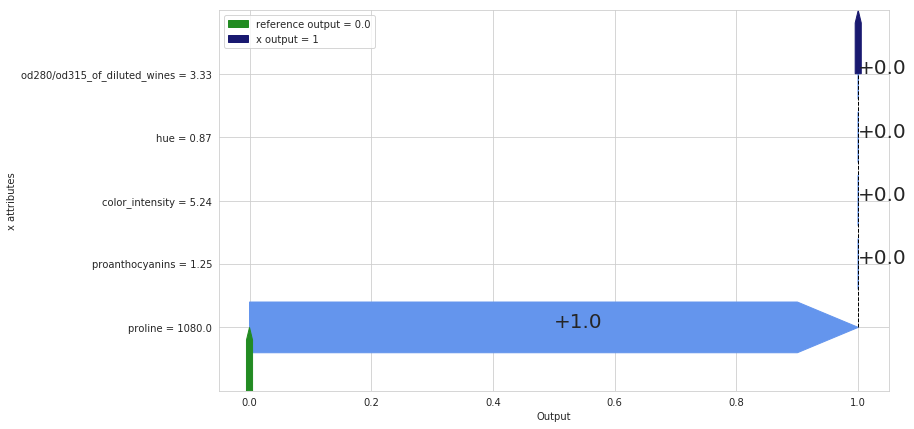

In [13]:
plot_shapley(x=x, fc=fc, ref=references, shapley_values=mc_shaps, n_attributes=5)